In [ ]:
pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.0 MB/s eta 0:00:00


In [ ]:
# This block of code sets up an environment for working with image processing tasks using the StarDist model, and imports all the necessary libraries and functions to facilitate the training

from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
# Read in the training data (images and their corresponding masks)
# Before running this code, make sure the folder containing the images and masks are saved as a zip file
# Run the code and select the zip file to upload the data
from google.colab import files # Import he Path object from the google.colab module
import os
import shutil

# Upload the zip file
uploaded = files.upload()

# Extract the uploaded zip file
for filename in uploaded.keys():
    # Create a directory with the same name as the zip file (without the .zip extension)
    folder_name = os.path.splitext(filename)[0]
    os.makedirs(folder_name, exist_ok=True)
    # Extract the contents of the zip file into the newly created directory
    shutil.unpack_archive(filename, folder_name)
    print(f"Uploaded folder '{folder_name}'")

Saving data_training.zip to data_training.zip
Uploaded folder 'data_training'


In [ ]:
# Check the file structure
!find data_training -type d | sed -e "s/[^-][^\/]*\// |/g" -e "s/|\([^ ]\)/|-\1/"

data_training
 |-data
 | |-train
 | | |-images
 | | |-masks
 | |-test
 | | |-images
 | | |-masks


In [ ]:
# Check that the data are correctly read in and assign variable to the images and their corresponding masks
from pathlib import Path  # Import the Path object from the pathlib module

X = sorted(glob('data_training/data/train/images/*.tif'))
Y = sorted(glob('data_training/data/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

# Print the list of files returned by the glob function call for X and Y
print("Files found in images folder:")
print(X)
print("\nFiles found in masks folder:")
print(Y)

Files found in images folder:
['data_training/data/train/images/15A_cores_13 (1, x=1690, y=1262, w=301, h=301).tif', 'data_training/data/train/images/15A_cores_13 (1, x=2478, y=1755, w=301, h=301).tif', 'data_training/data/train/images/15A_cores_13 (1, x=982, y=2095, w=301, h=301).tif', 'data_training/data/train/images/15A_cores_17 (1, x=1159, y=1602, w=301, h=301).tif', 'data_training/data/train/images/15A_cores_17 (1, x=1780, y=667, w=301, h=301).tif', 'data_training/data/train/images/16A_cores_1 (1, x=1010, y=2542, w=301, h=301).tif', 'data_training/data/train/images/16A_cores_1 (1, x=1465, y=798, w=301, h=301).tif', 'data_training/data/train/images/16A_cores_1 (1, x=2020, y=1549, w=301, h=301).tif', 'data_training/data/train/images/16A_cores_10 (1, x=1612, y=2265, w=301, h=301).tif', 'data_training/data/train/images/16A_cores_10 (1, x=2404, y=1795, w=301, h=301).tif', 'data_training/data/train/images/16A_cores_10 (1, x=979, y=570, w=301, h=301).tif', 'data_training/data/train/image

In [ ]:
# Save the images in a list
X = list(map(imread,X))
Y = list(map(imread,Y))

In [ ]:
# Check the label, shapes, and dimensions of the images to ensure they are valid for use in the training
# This code selects a specific image and its label (at index i) for further processing, assuming that X and Y are lists or arrays containing image data and their corresponding labels

if len(X) > 0:    # Check if X has at least one element
    # Calculate the index i as the minimum value between 4 and one less than the length of X
    i = min(4, len(X) - 1)
    # Access elements from X and Y at index i
    img, lbl = X[i], fill_label_holes(Y[i])
    assert img.ndim in (2, 3)
    img = img if img.ndim == 2 else img[..., :3]
    # assumed axes ordering of img and lbl is: YX(C)
else:
    print("X has no elements. Please check the directory or the file naming.")

In [ ]:
# Use the example image selected above to comfirm the dimensions of images and masks
print("Image shape:", img.shape)
print("Label shape:", lbl.shape)

Image shape: (301, 301, 3)
Label shape: (301, 301)


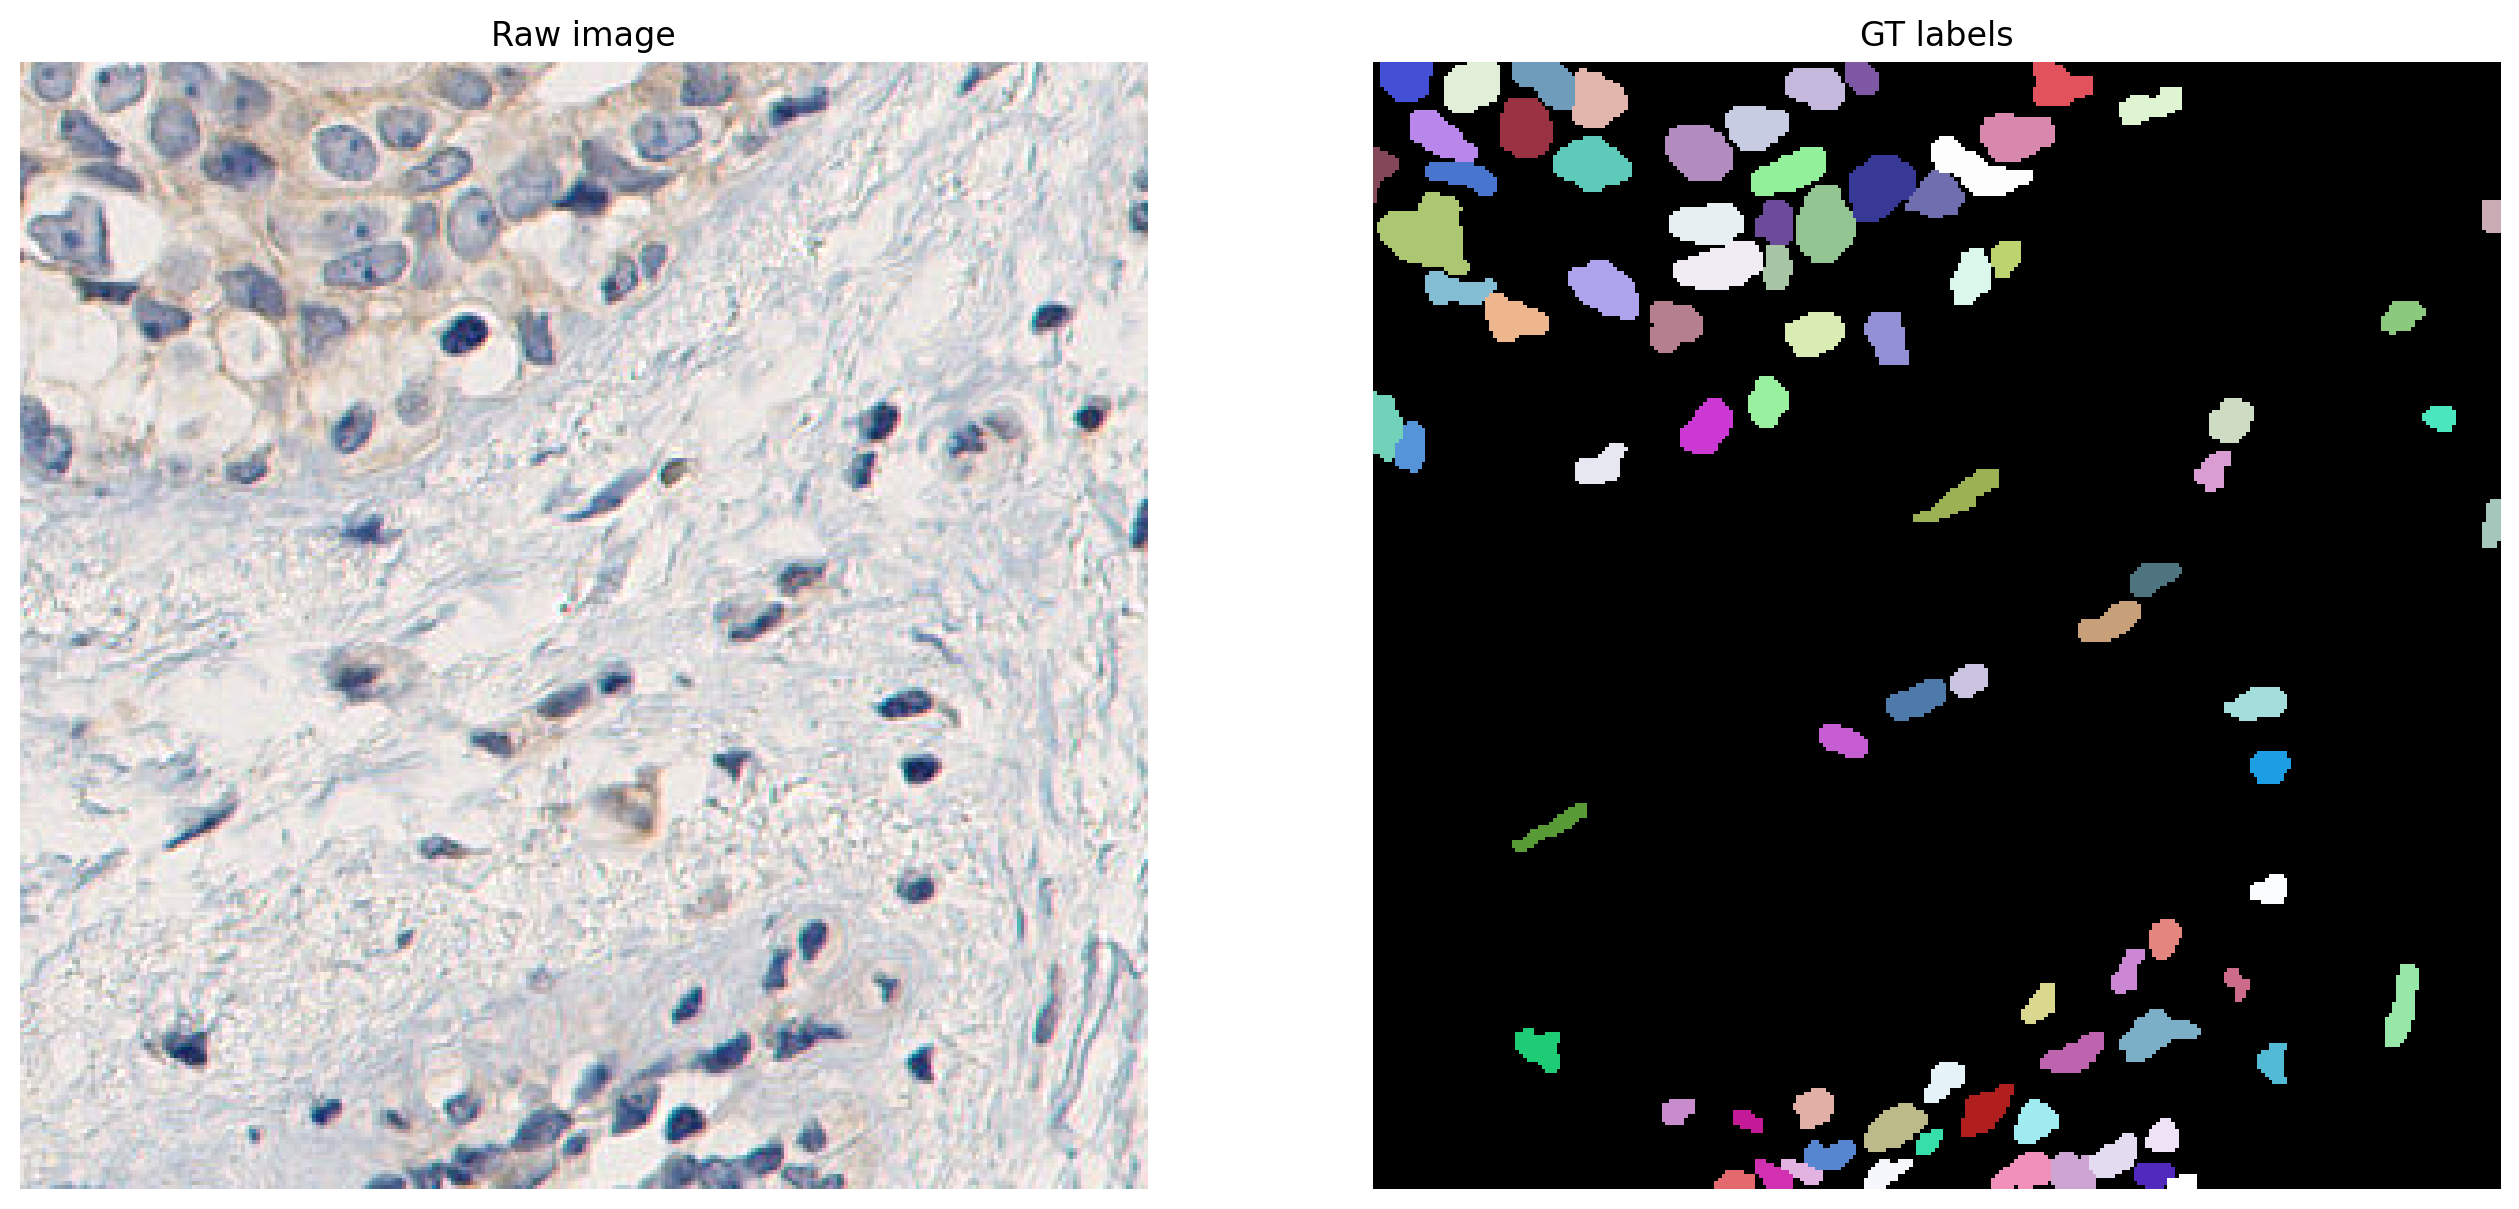

In [ ]:
# Preview the raw and ground truth label of the image
plt.figure(figsize=(16,10))  # Set plot size
plt.subplot(121); plt.imshow(img,cmap='gray'); plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [ ]:
# This evaluates the performance of the data with the StarDist model using different numbers of rays `(n_rays)
# It reconstructs the labels and calculates the mean Intersection over Union (IoU) scores for each configuration.

n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
    mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [00:26<00:00,  4.46s/it]


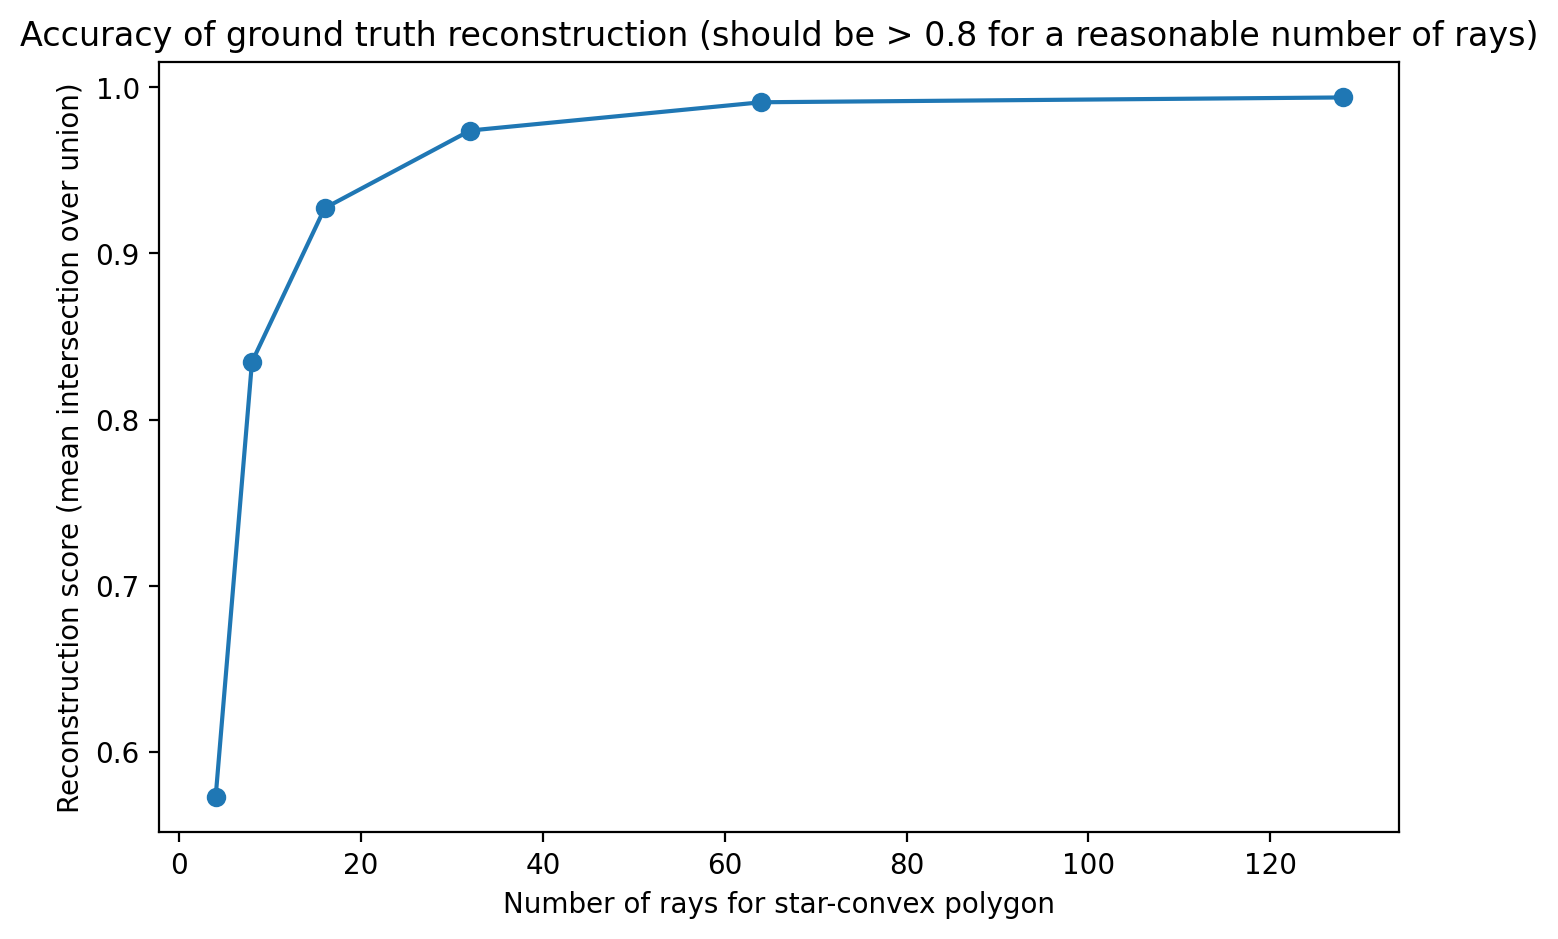

In [ ]:
# Create a plot showing the relationship between the number of rays used in the StarDist model and the reconstruction score (the mean IoU between the original labels and the reconstructed labels)
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

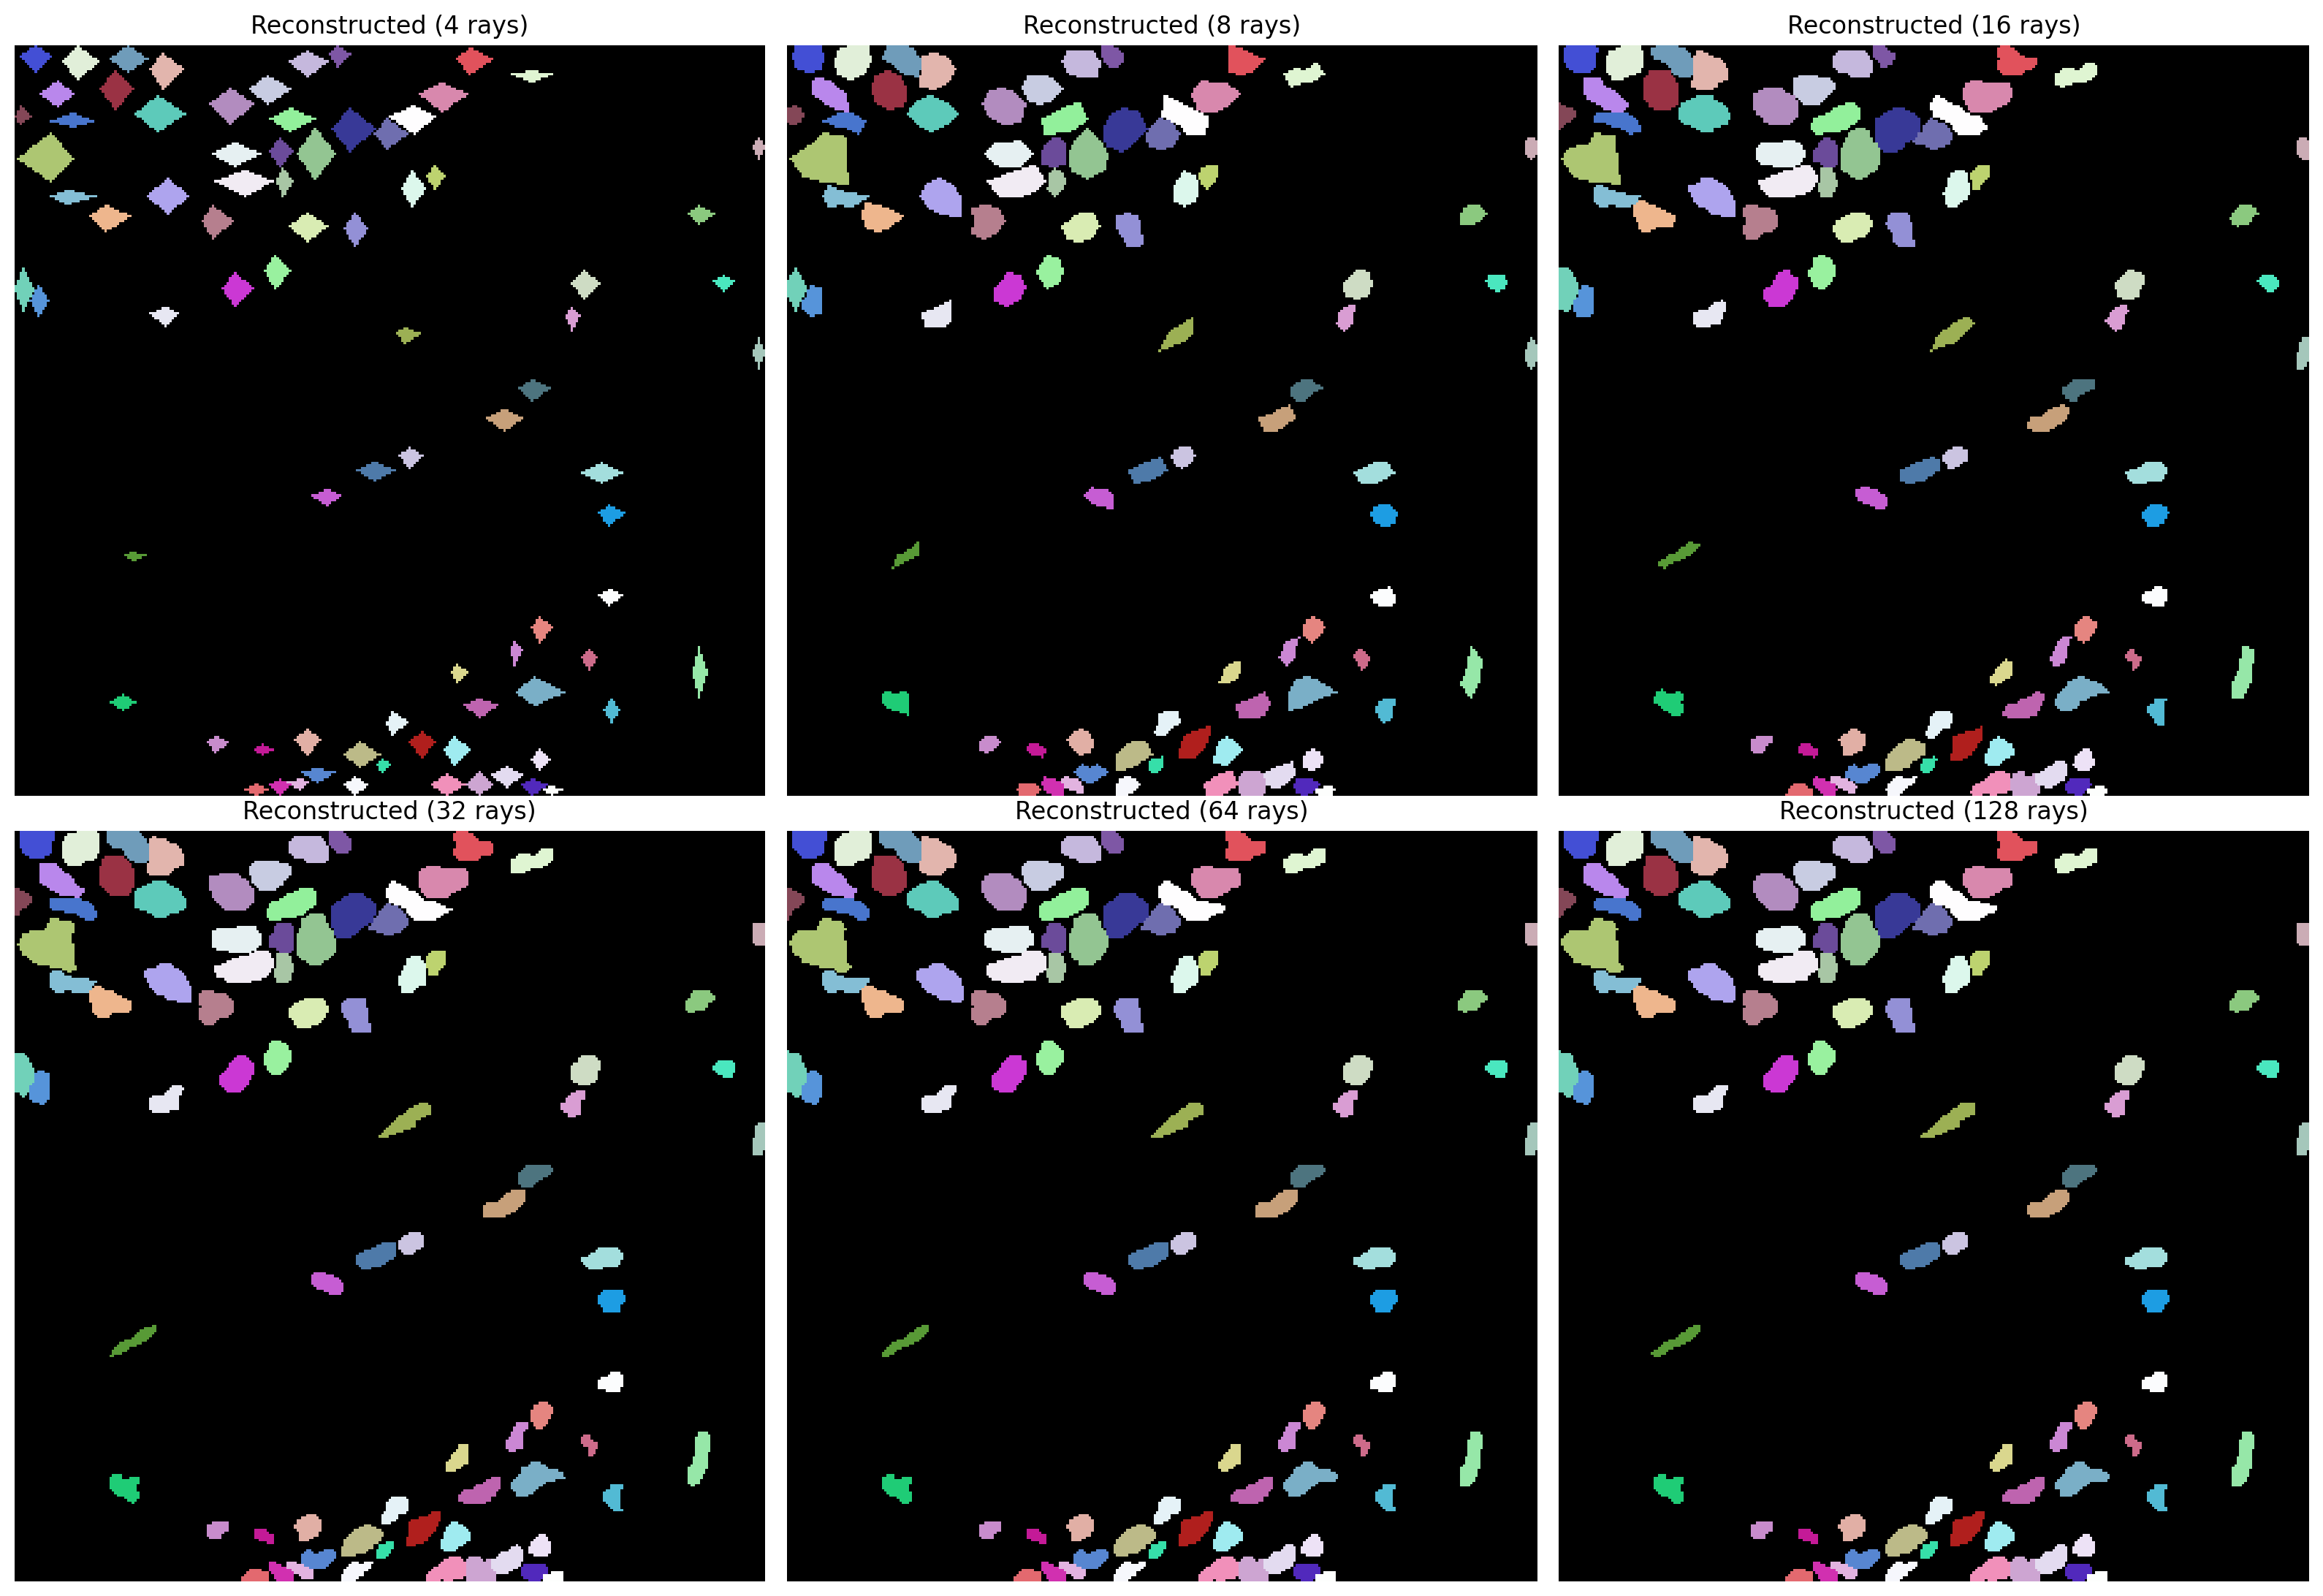

In [ ]:
# Reconstruct the example image with various number of rays
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();